In [1]:
import pandas as pd
import numpy as np
import string 

df = pd.read_csv('training.1600000.processed.noemoticon.csv', sep=',', encoding='latin-1',  header=None)
df.columns = ["target","ids","date","flag","user","text"]
df = df.drop(["ids","date","flag","user"], axis = 1)
df.head()


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Przetwarzanie danych
- Usunięcie znaków specjalnych
- Zamiana tekstu na małe litery
- Usunięcie stop-słów
- Lematyzacja
- Obsługa emotikonów
- Obsługa błędów ortograficznych
- Usunięcie nicków i linków

In [2]:
import spacy
from nltk.tokenize.casual import EMOTICON_RE

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

stop_words = pd.read_csv('stop_words.txt')
stop_words = stop_words.loc[:,'word'].tolist()
stopwords_simple = [word.replace("'", "") for word in stop_words]
stop_words = set(stop_words + stopwords_simple)

misspelled_words = pd.read_csv('misspelled_words.txt',sep='->')
misspelled_words = dict(zip(misspelled_words['miss'], misspelled_words['target']))

def preprocess_text(text):
    # Filter out misspelled words
    words = text.split()
    words = [misspelled_words[word.lower()] if word.lower() in misspelled_words else word for word in words]
    doc = nlp(' '.join(words))
    [print(word.lemma_) for word in doc]
    # Tokenize, lemmatize, and filter out punctuation, special characters, lowercase
    # Preserve emoticons
    words = [token.lemma_.lower() for token in doc if 
             (token.lemma_.isalpha() and token.lemma_.isascii() and not token.is_punct)
             or EMOTICON_RE.match(token.text)]
    print(words)
    # Remove stopwords nicknames and links
    words = [word for word in words if word not in stop_words] 
    words = [word for word in words if not word.startswith(('@', 'http', 'https', 'www.'))]
    return words 

C:\Users\Filip\AppData\Local\Temp\ipykernel_2620\942341947.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  misspelled_words = pd.read_csv('misspelled_words.txt',sep='->')


In [3]:
import os.path
fname = 'tokenized.gzip'
if os.path.isfile(fname):
    print("Loading saved file")
    df = pd.read_pickle('tokenized.gzip', compression='gzip')
else:
    print("Preprocessing text")
    df['text'] = df['text'].apply(lambda x: preprocess_text(x))
    df.loc[df['target'] == 4, 'target'] = 1
    # Save to file
    df.to_pickle('tokenized.gzip',
                compression='gzip') 
df.head()


Loading saved file


,target,text
0,0,"[awww, bummer, you, shoulda, get, david, carr,..."
1,0,"[upset, he, can, not, update, his, facebook, t..."
2,0,"[dive, many, time, ball, manage, save, 50, res..."
3,0,"[my, whole, body, feel, itchy, and, like, its,..."
4,0,"[no, not, behave, all, mad, why, here, because..."


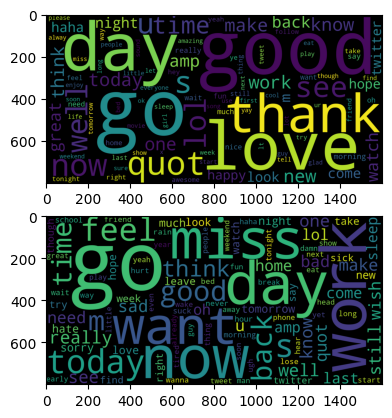

In [4]:
from wordcloud import WordCloud
from matplotlib.pyplot import subplots
positive_words = [word for words in df.loc[df['target'] == 1, 'text'].values.tolist() for word in words]
negative_words = [word for words in df.loc[df['target'] == 0, 'text'].values.tolist() for word in words]
pos_wc = WordCloud(max_words=100, width=1600, height=800, collocations=False).generate(' '.join(positive_words))
neg_wc = WordCloud(max_words=100, width=1600, height=800, collocations=False).generate(' '.join(negative_words))

fig, ax = subplots(nrows=2, ncols=1)
ax[0].imshow(pos_wc)
ax[1].imshow(neg_wc)

### Train test split

In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, random_state = 0)

### Vectorization

In [6]:
import os

# Only the TensorFlow backend supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import numpy as np
import tensorflow.data as tf_data
import keras
from keras import layers
from keras.layers import Embedding

In [7]:
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=100)
text_ds = tf_data.Dataset.from_tensor_slices(train_df['text'].apply(lambda x: ' '.join(x)).tolist()).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc,range(len(voc))))

In [8]:
# Glove embedding
# Download https://nlp.stanford.edu/data/glove.twitter.27B.zip 
# and extract glove.twitter.27B.100d.txt file
path_to_glove_file = "glove.twitter.27B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1193514 word vectors.


In [9]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
missed = []
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        missed.append(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18079 words (1921 misses)


### Deep CNN model

In [10]:
net_train_df, val_df = train_test_split(train_df, test_size=0.2)
def getX(df):
    return vectorizer(np.array(df['text'].apply(lambda x: [' '.join(x)]).tolist())).numpy()

x_train = getX(net_train_df)
x_val = getX(val_df)
x_test = getX(test_df)
y_train = net_train_df['target'].to_numpy()
y_val = val_df['target'].to_numpy()
y_test = test_df['target'].to_numpy()


In [11]:

model_path = 'cnn_model.keras'
if os.path.isfile(model_path):
    model = keras.models.load_model(model_path)
else:
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        trainable=False,
    )
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    int_sequences_input = keras.Input(shape=(None,), dtype="int32")
    embedded_sequences = embedding_layer(int_sequences_input)
    x = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    preds = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(int_sequences_input, preds)
    model.save('cnn_model.keras')

    # Train
    model.compile(
        loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"]
    )
    model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_val, y_val))
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 100)      │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, None, 128)      │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, None, 128)      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, None, 128)      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307,660 (8.80 MB)

 Trainable params: 153,729 (600.50 KB)

 Non-trainable params: 2,000,200 (7.63 MB)

 Optimizer params: 153,731 (600.52 KB)

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
    
vectorizer
y_pred = model.predict(x_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
print("Dokładność modelu:", accuracy_score(y_test, y_pred))
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step
Dokładność modelu: 0.8070416666666667
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81    239877
           1       0.83      0.78      0.80    240123

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000

